In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


# Race Data Exploration

The following data explores notable information obtained from 4 data sets. Each data set include bicycle race data from the same track over multiple races in the year's 2016 and 2019. The track located in Calga has 2 modes of races:
1. A Time Trial. Where the rider completes one lap by themselves
2. A Road Race. Where the rider rides with a peleton

## Overall Comparison

The below table outlines and provides a high-level view of important features contained in the 4 data sets. 

*Note: table date is rounded to 2 decimal places*

In [4]:
# Creating a new Data Frame containing specific race data for comparison
data = {'Average Speed (Km/h)':[tt_2016.speed.mean(), rr_2016.speed.mean(), tt_2019.speed.mean(), rr_2019.speed.mean()], 
        'Distance (km)':[tt_2016.distance.sum(), rr_2016.distance.sum(), tt_2019.distance.sum(), rr_2019.distance.sum()],
        'Cadence Average (rpm)':[tt_2016.cadence.mean(), rr_2016.cadence.mean(), tt_2019.cadence.mean(), rr_2019.cadence.mean()],
        'Heart Rate (bpm)':[tt_2016.hr.mean(), rr_2016.hr.mean(), tt_2019.hr.mean(), rr_2019.hr.mean()],
        'Total Time (minutes)':[tt_2016.timedelta.sum()/60, rr_2016.timedelta.sum()/60, tt_2019.timedelta.sum()/60, rr_2019.timedelta.sum()/60]}
comparisonDF = pd.DataFrame(data, index=['Time Trial 2016', 'Road Race 2016', 'Time Trial 2019', 'Road Race 2019'])
comparisonDF.round(2)

,Average Speed (Km/h),Distance (km),Cadence Average (rpm),Heart Rate (bpm),Total Time (minutes)
Time Trial 2016,33.53,24.80,83.28,170.94,45.78
Road Race 2016,34.93,49.05,65.99,158.39,86.67
Time Trial 2019,33.06,24.38,89.98,152.74,44.23
Road Race 2019,33.88,51.79,70.00,139.00,91.70


## Total Distance's

To visualise the total distance's travelled by the rider, a bar chart is used to outlined the distances for each race. 

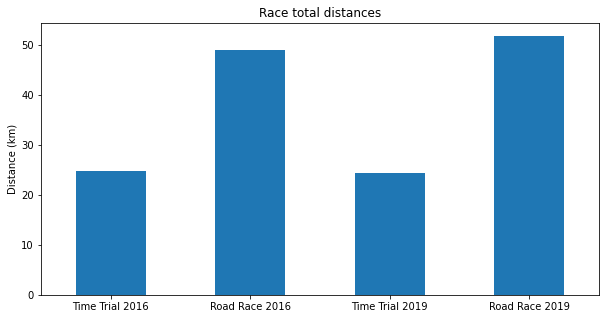

In [5]:
# Bar chart from comparisonDF 
plt.figure(figsize=(10,5))
ax = comparisonDF['Distance (km)'].plot.bar(rot=0)
ax.set_title('Race total distances')
temp = ax.set_ylabel('Distance (km)')

The above output shows that the road race's are longer than the time trial. This is supported by the fact that Road Race's have 2 laps compaired to a single lap in the Time Trial's 

## Heart Rate Distribution

The following histograms are used to show the distribution of heart rate achieved by the rider over each race. 

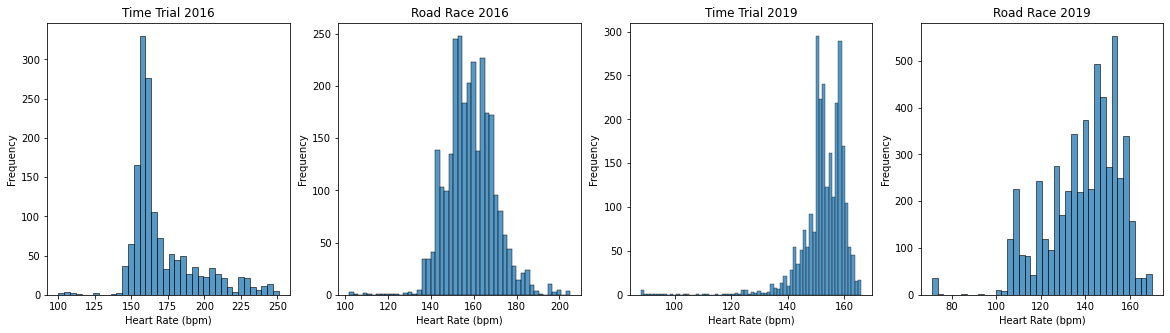

In [6]:
# Histograms for race heart rate distribution
fig, ax =plt.subplots(1,4, figsize=(20,5))
tt_HR_2016 = sns.histplot(tt_2016.hr, ax=ax[0])
tt_HR_2016.set(xlabel='Heart Rate (bpm)', ylabel='Frequency', title='Time Trial 2016')
rr_HR_2016 = sns.histplot(rr_2016.hr ,ax=ax[1])
rr_HR_2016.set(xlabel='Heart Rate (bpm)', ylabel='Frequency', title='Road Race 2016')
tt_HR_2019 = sns.histplot(tt_2019.hr, ax=ax[2])
tt_HR_2019.set(xlabel='Heart Rate (bpm)', ylabel='Frequency', title='Time Trial 2019')
rr_HR_2019 = sns.histplot(rr_2019.hr, ax=ax[3])
tempHRGraph = rr_HR_2019.set(xlabel='Heart Rate (bpm)', ylabel='Frequency', title='Road Race 2019')

The histograms above show some consitancy between race types. A significant significant portion of measured heart rates are between 150 and 180. 

There are two noteworthy points in these graphs: 
1. In the 2016 Time Trial, it appears the riders heart rate is measured above 200 consitantly and as high as 250. This could be attributed to an error in the measurements at the time the data was collected. 
2. The heart rates measured in the 2019 Road Race apear to trend below 140. Taking into acount that this race had taken only around 4 minutes longer than the 2016 Road Race, it can be assumed that the rider's fitness had increased 

## Heart Rate Over Time 

To visualise the riders Heart Rate over time, the following line graphs are generated to display these values 

In [7]:
# Heart Rate over Time graph function 
def hrOverTime(data):
    df = data.copy()
    df['Elapsed_Time'] = data.timedelta.cumsum()/60
    plt.figure(figsize=(20,6))
    linePlot = sns.lineplot(data=df, x='Elapsed_Time', y=df.hr.rolling(5).mean())
    tempLinePlot = linePlot.set(xlabel='Elapsed Time (minutes)', ylabel='Heart Rate (bpm)', title='Heart Rate Over Time')
    return linePlot

### Time Trial 2016

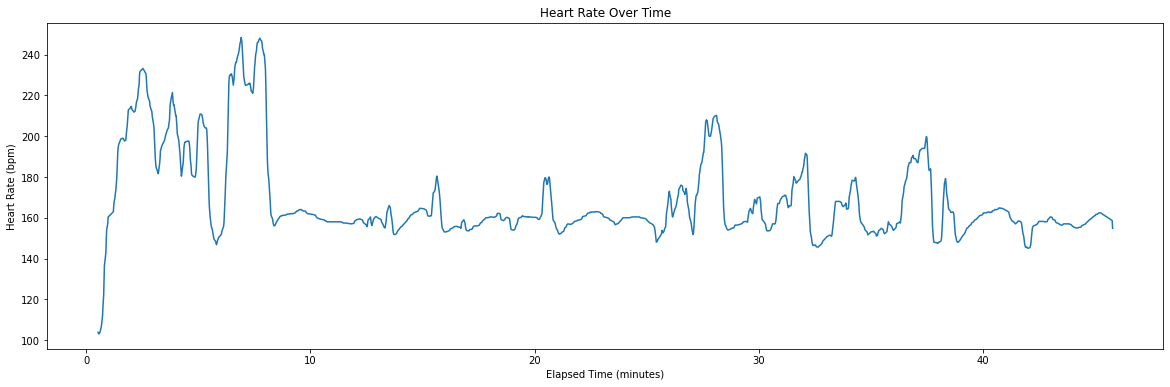

In [8]:
df = hrOverTime(tt_2016)

### Road Race 2016

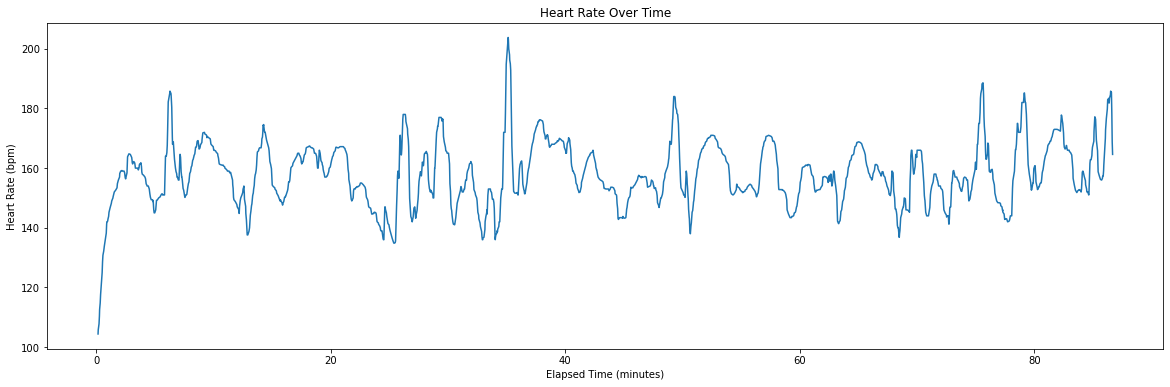

In [9]:
df = hrOverTime(rr_2016)

### Time Trial 2019

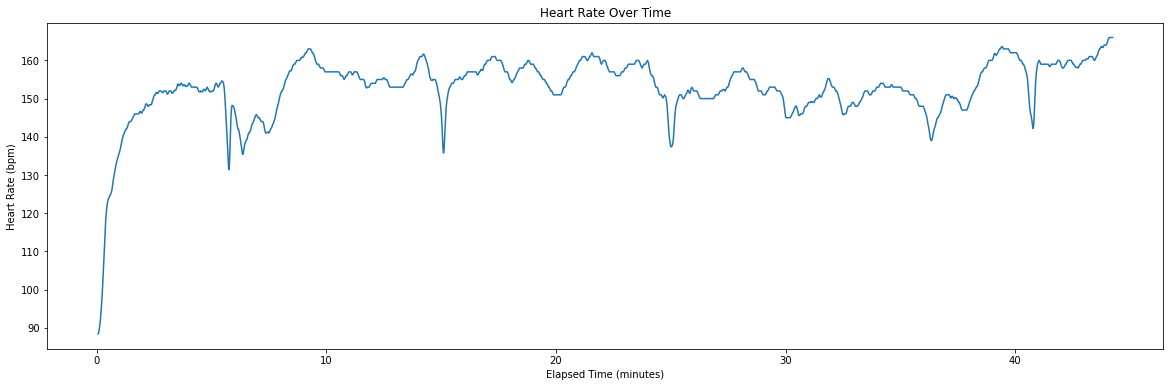

In [10]:
df = hrOverTime(tt_2019)

### Road Race 2019

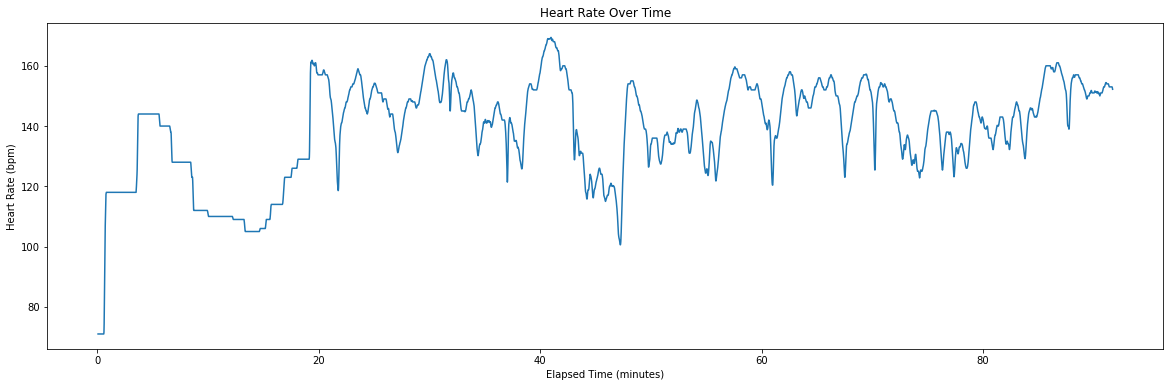

In [11]:
df = hrOverTime(rr_2019)

Here the graphs above show that the variation of heart rates in the Road Race's is greater than that of the Time Trials. This shows that at time throughout the race, riding with a peleton can be physically easier on the rider than riding alone in the Time Trials 

## Cadence Distribution

The below histograms are used to visualise the distribution of Cadence over the 4 data sets. 

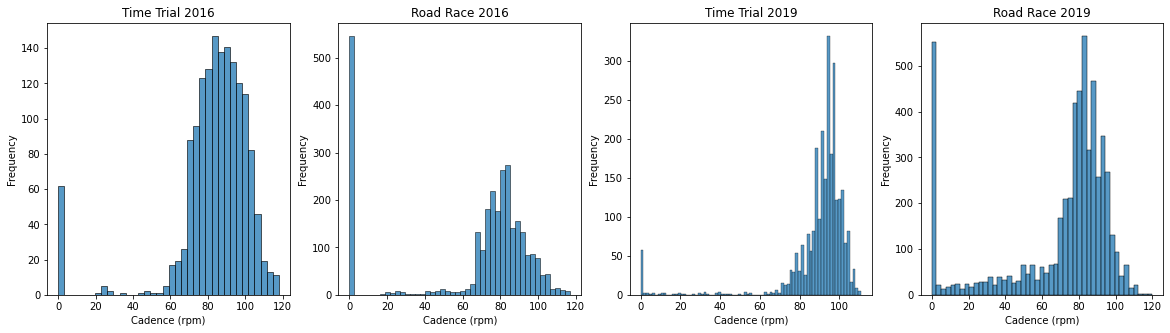

In [12]:
# Histograms for race cadence distribution
fig, ax =plt.subplots(1,4, figsize=(20,5))
tt_Cadence_2016 = sns.histplot(tt_2016.cadence, ax=ax[0])
tt_Cadence_2016.set(xlabel='Cadence (rpm)', ylabel='Frequency', title='Time Trial 2016')
rr_Cadence_2016 = sns.histplot(rr_2016.cadence, ax=ax[1])
rr_Cadence_2016.set(xlabel='Cadence (rpm)', ylabel='Frequency', title='Road Race 2016')
tt_Cadence_2019 = sns.histplot(tt_2019.cadence, ax=ax[2])
tt_Cadence_2019.set(xlabel='Cadence (rpm)', ylabel='Frequency', title='Time Trial 2019')
rr_Cadence_2019 = sns.histplot(rr_2019.cadence, ax=ax[3])
tempCadenceGraph = rr_Cadence_2019.set(xlabel='Cadence (rpm)', ylabel='Frequency', title='Road Race 2019')

Notably the majority cadence records across all 4 rides, sits roughly between 60 - 110rpm. A cadence of 0rpm is also recorded frequently, indicating how often the rider does not exert effort onto the pedals. As both Road Races have recored 0rpm greater than 500 times, compared to the Time Trials significantly lower frequency, it is clear Road Race's physical intensity is lower than that of Time Trials. 

## Cadence Over Distance 

To view the locations where the rider exerts effort, the below line grpahs display the distance against the riders cadence. 

In [13]:
# Cadence over distance graph function 
def cadenceOverDist(data):
    df = data.copy()
    df['Cumulative_Dist'] = data.distance.cumsum()
    plt.figure(figsize=(20,6))
    linePlot = sns.lineplot(data=df, x='Cumulative_Dist', y='cadence')
    tempLinePlot = linePlot.set(xlabel='Distance (Km)', ylabel='Cadence (rpm)', title='Cadence Over Distance')
    return linePlot

### Time Trial 2016

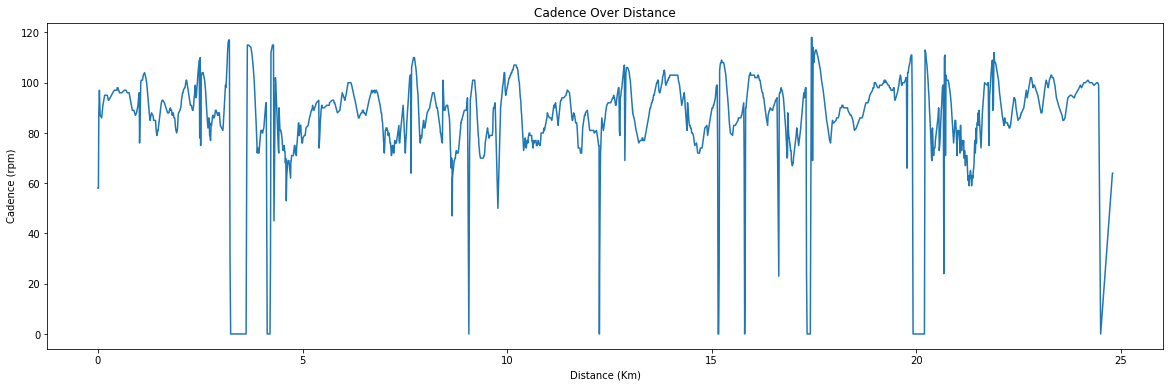

In [14]:
df = cadenceOverDist(tt_2016)

### Road Race 2016

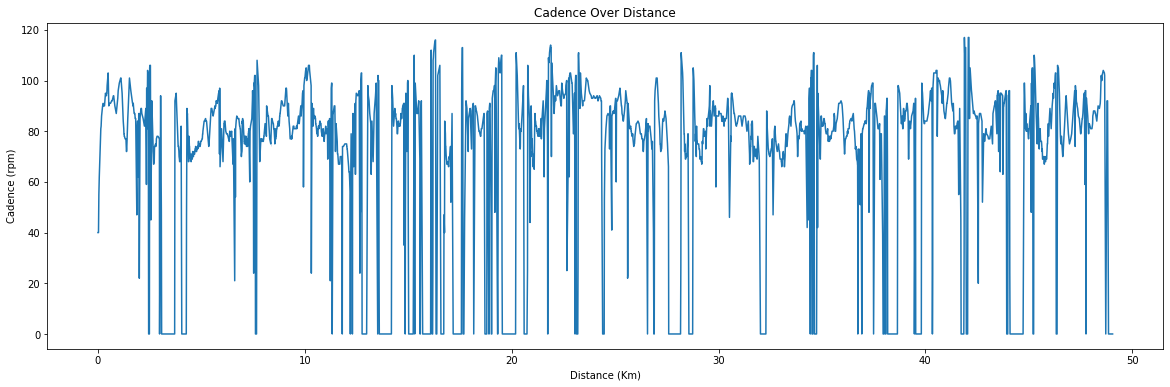

In [15]:
df = cadenceOverDist(rr_2016)

### Time Trial 2019

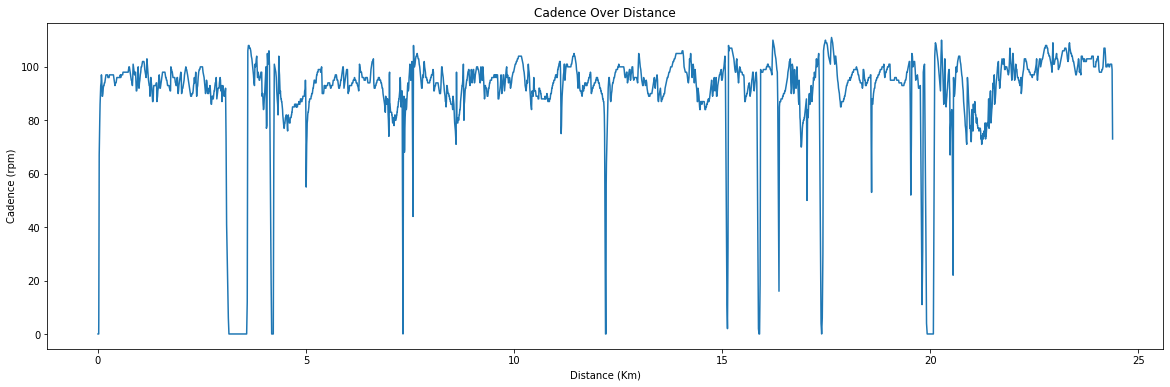

In [16]:
df = cadenceOverDist(tt_2019)

### Road Race 2019

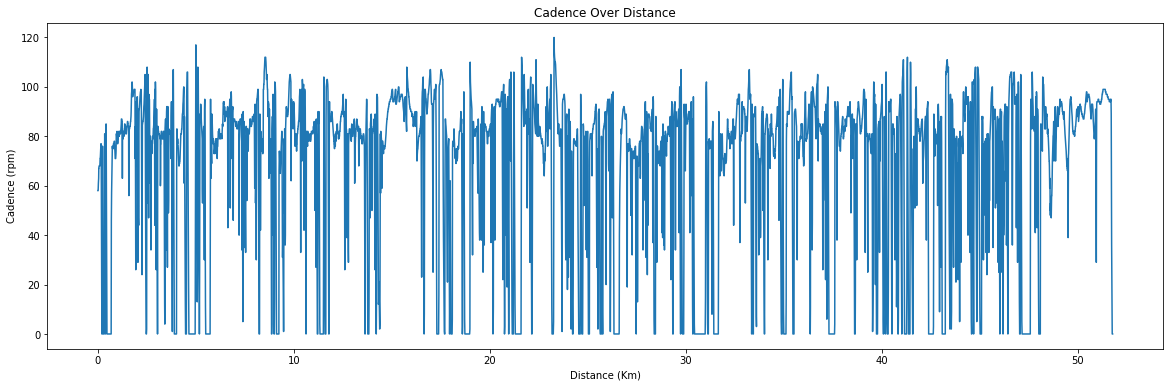

In [17]:
df = cadenceOverDist(rr_2019)

With the above it is again most notable that Road Races require less consistant effort than that of Time Trials. 

## Speed Comparision

To compare the speeds for each race against each other. The below Box Plot and race averages are used. 

*Note: Table rounded to 2 decimal places*

In [18]:
# Print race averages
print('Average Speed (Km/h)\n')
print(comparisonDF['Average Speed (Km/h)'].round(2))

Average Speed (Km/h)

Time Trial 2016    33.53
Road Race 2016     34.93
Time Trial 2019    33.06
Road Race 2019     33.88
Name: Average Speed (Km/h), dtype: float64


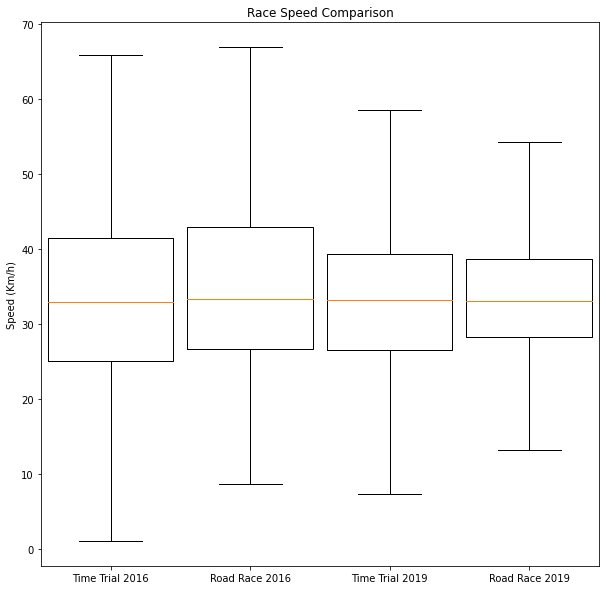

In [19]:
# Box plot for race averages
speedCompArray = [tt_2016.speed.to_numpy(), rr_2016.speed.to_numpy(), tt_2019.speed.to_numpy(), rr_2019.speed.to_numpy()]
plt.figure(figsize=(10,10))
plt.title('Race Speed Comparison')
plt.ylabel('Speed (Km/h)')
speedBoxPlot = plt.boxplot(speedCompArray, 
                           showfliers=False, 
                           labels=['Time Trial 2016','Road Race 2016',
                                   'Time Trial 2019','Road Race 2019'],
                           widths=0.90,)

Based on the above, it apears that Road Races are slightly faster than Time Trials

## Time Trial Speed (2016 vs. 2019)

To compare the two time trials, the data is explored with their averges, difference and a line graph

*Note:* 
- Speeds rounded to 2 decimal places
- Difference rounded to 4 decimal places

In [20]:
# Data frame of Time Trial averages 
tt2016Avg = [tt_2016.speed.mean()]
tt2019Avg = [tt_2019.speed.mean()]
ttSpeed = {'2016': tt2016Avg, '2019': tt2019Avg}
ttSpeedDF = pd.DataFrame(ttSpeed)
ttSpeedDF.rename(index={0: 'Time Trial Avergae Speed'}, inplace=True)
ttSpeedDF = ttSpeedDF.transpose()
ttSpeedDF.round(2)

,Time Trial Avergae Speed
2016,33.53
2019,33.06


In [21]:
# Time Trail Average Speed Difference 
diff = ttSpeedDF.loc['2016'] - ttSpeedDF.loc['2019']
print('Average Speed Difference: ', diff[0].round(4))

Average Speed Difference:  0.4721


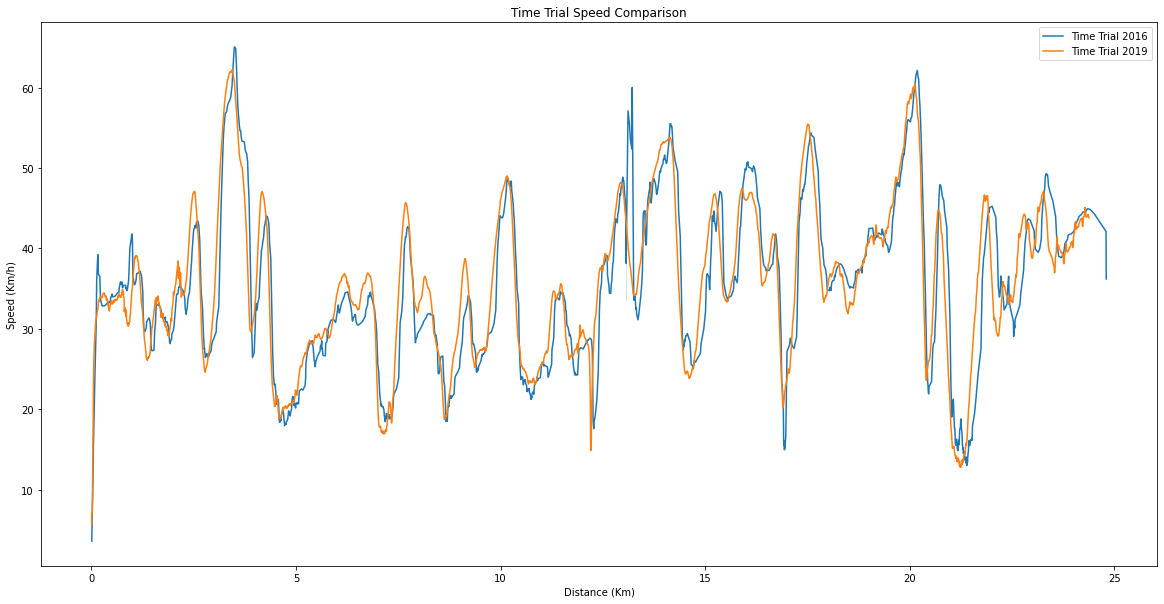

In [22]:
# Time Trial speed comparison graph
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=tt_2016, x=tt_2016.distance.cumsum(), y=tt_2016.speed.rolling(5).mean(), label='Time Trial 2016')
sns.lineplot(data=tt_2019, x=tt_2019.distance.cumsum(), y=tt_2019.speed.rolling(5).mean(), label='Time Trial 2019', ax = ax)
ax.set_title('Time Trial Speed Comparison')
ax.set_ylabel('Speed (Km/h)')
temp = ax.set_xlabel('Distance (Km)')

As seen above, the time trial 2016 is on average faster by 0.4721 (km/h). 

In the line graph above, it is clear where one race is faster than the other:
- 2019 is faster between Km 4-10
- 2016 is faster between Km 

## Climbing, Decending & Flat Speeds

The following analysis will explore the average speeds of three catagories Climbing, Decending, and Flat. 

*Note: Table is rounded to 2 decimal places*

In [23]:
# Elevation Speeds Function
def elevSpeed(data):
    climb = data[data.elevation_gain > 0.4]
    decent = data[data.elevation_gain < -0.4]
    flat = data[(data.elevation_gain > -0.4) & (data.elevation_gain < 0.4)]
    climb = [climb.speed.mean()]
    decent = [decent.speed.mean()]
    flat = [flat.speed.mean()]
    df = {'Climb': climb, 'Decent': decent, 'Flat': flat}
                                                         
    return pd.DataFrame(df)

In [24]:
# Combining all race averages into one data frame
elSpeed = elevSpeed(tt_2016)
elSpeed.rename(index={0: 'Time Trial 2016'}, inplace=True)
elSpeed = elSpeed.append(elevSpeed(rr_2016))
elSpeed.rename(index={0: 'Road Race 2016'}, inplace=True)
elSpeed = elSpeed.append(elevSpeed(tt_2019))
elSpeed.rename(index={0: 'Time Trial 2019'}, inplace=True)
elSpeed = elSpeed.append(elevSpeed(rr_2019))
elSpeed.rename(index={0: 'Road Race  2019'}, inplace=True)
elSpeed.round(2)

,Climb,Decent,Flat
Time Trial 2016,24.73,45.26,32.82
Road Race 2016,26.31,46.68,33.78
Time Trial 2019,22.97,48.55,32.21
Road Race 2019,27.51,47.18,32.78


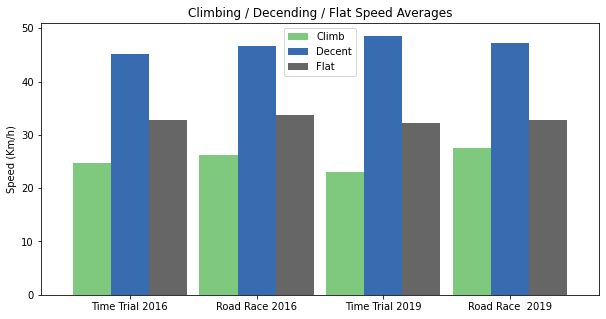

In [25]:
# Bar graph for each race 
temp = elSpeed.plot.bar(width=0.9, figsize=(10, 5), cmap='Accent', ylabel='Speed (Km/h)', 
                        title='Climbing / Decending / Flat Speed Averages')
temp = plt.xticks(rotation=0)


In [26]:
# Global race data averages
elSpeedMean = elSpeed.mean(axis=0).to_frame()
elSpeedMean = elSpeedMean.transpose()
elSpeedMean.rename(index={0: 'Global Average'}, inplace=True)
elSpeedMean

,Climb,Decent,Flat
Global Average,25.379396,46.917309,32.897863


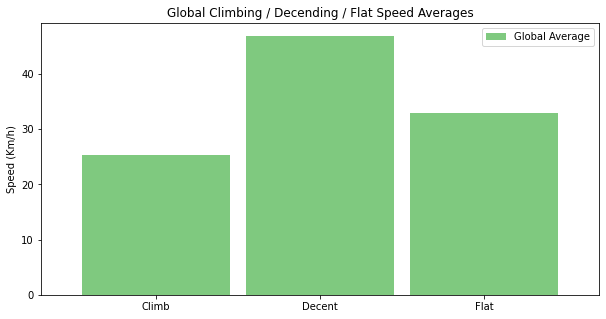

In [27]:
# Bar graph for global averages 
elSpeedMean = elSpeedMean.transpose()
ax = elSpeedMean.plot.bar(width=0.9, figsize=(10, 5), cmap='Accent')
ax.set_title('Global Climbing / Decending / Flat Speed Averages')
ax.set_ylabel('Speed (Km/h)')
temp = plt.xticks(rotation=0)

As displayed above, Decending is the fastest and Climbing is the slowest. This outcome is reasonable due to the efforts required for the rider in each situation. These trends are also consistant accross all races

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





In [28]:
#Development conversion function
def development(data):
    tempDF = pd.DataFrame([data.speed, data.cadence]).transpose()
    tempDF['speed'] = (tempDF['speed']*1000) / 60
    tempDF['development'] = (tempDF['speed']) / tempDF['cadence']
    tempDF = tempDF.drop(tempDF[(tempDF.development < 2) | (tempDF.development > 10)].index)
    return tempDF

[Text(0.5, 1.0, 'Road Race 2019')]

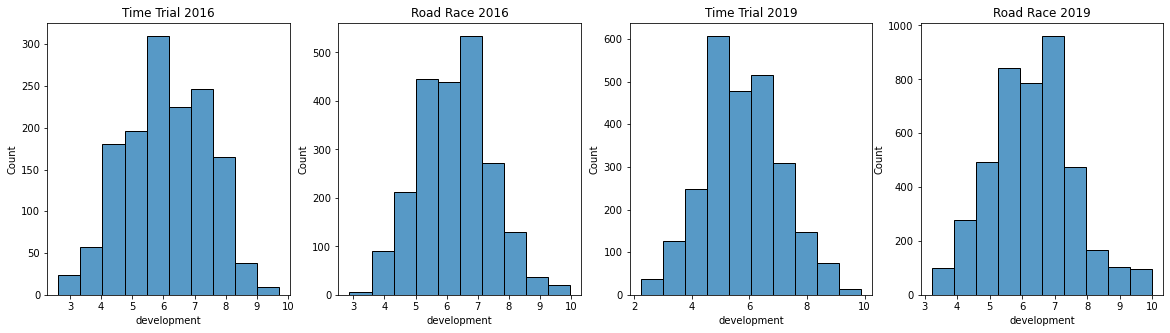

In [29]:
fig, ax =plt.subplots(1,4, figsize=(20,5))

# Time Trial 2016 development grpah
tt_2016_dev = development(tt_2016)
tt_2016_dev_graph = sns.histplot(tt_2016_dev.development, ax=ax[0], bins=10)
tt_2016_dev_graph.set(title='Time Trial 2016')

# Road Race 2016 development grpah
rr_2016_dev = development(rr_2016)
rr_2016_dev_grpah = sns.histplot(rr_2016_dev.development, ax=ax[1], bins=10)
rr_2016_dev_grpah.set(title='Road Race 2016')

# Time Trial 2019 development grpah
tt_2019_dev = development(tt_2019)
tt_2019_dev_grpah = sns.histplot(tt_2019_dev.development, ax=ax[2], bins=10)
tt_2019_dev_grpah.set(title='Time Trial 2019')

# Road Race 2019 development grpah
rr_2019_dev = development(rr_2019)
rr_2019_dev_grpah = sns.histplot(rr_2019_dev.development, ax=ax[3], bins=10)
rr_2019_dev_grpah.set(title='Road Race 2019')

Based on the above histograms, the rider tends to favour a certain range of gears that produce a range of development 5 and 7 meters. Although, Time Trial 2016 tends to favour a range between 6 and 8 meters. 

However, each ride does tend to favour a range of gears that produce a range of speeds. This appears to be within the middle of the gear ranges of the bike. 

# Conclusion 

In conclusion the data analysis has proven to be useful in gaining insight to the riders performance in all races. The main insights gained from the data are summerised below: 

The majority of heart rates measured sit around the 150-180 beats per minute. Notably the heart rates in the Road Races vary significantly more than that of Time Trials. The cadence produced by the rider sits roughly between 60 - 110rpm. Again with the greater variation with Road Races. With this information it seems reasonable to conclude that Road Races are measurably easier on the rider physically than that of Time Trials. 

Analysing the speeds achieved throughout has determined that Road Races are slightly faster than Time Trials. It has also been discovered that the average speeds of the rider when riding up hill, down hill and on a flat are all different.


Finally the gear usage by the rider tends to favour a gear range with a development of 5-7 meters in Road Races and Time Trials tends to favour a range between 6-8 meters. 